In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
import yfinance as yf
import scipy as sp
from cvxopt import matrix, solvers

In [7]:
def option_price_data(ticker):
    today = datetime.today()
    stock = yf.Ticker(ticker)
    
    # Fetch the live price
    S = stock.history(period="1d")['Close'][-1]

    # Fetch available maturities for options
    maturities = stock.options
    maturities_dates = [datetime.strptime(x, "%Y-%m-%d") for x in maturities]
    maturities_frac = [(x - today).days for x in maturities_dates if (x - today).days <= 600]

    # Ensure maturities and maturities_frac are aligned
    maturities = [m for m, x in zip(maturities, maturities_dates) if (x - today).days <= 600]

    # Get strikes and options data for the farthest maturity
    options_chain = stock.option_chain(maturities[-1])
    calls = options_chain.calls
    strikes = list(calls['strike'])

    # Intersect strikes for all maturities
    for mat in maturities:
        options_chain = stock.option_chain(mat)
        calls_n = options_chain.calls
        strikes = list(set(strikes).intersection(set(calls_n['strike'])))
    
    strikes.sort()
    # Exclude extreme strikes
    strikes = strikes[5:-5]
    
    option_prices = pd.DataFrame(index=maturities_frac, columns=strikes)
    option_bid = pd.DataFrame(index=maturities_frac, columns=strikes)
    option_ask = pd.DataFrame(index=maturities_frac, columns=strikes)
    
    # Fetch and compute bid, ask, and average prices for each maturity and strike
    for i, mat in enumerate(maturities):
        options_chain = stock.option_chain(mat)
        calls_n = options_chain.calls
        calls_n = calls_n[calls_n['strike'].isin(strikes)]
        
        for strike in strikes:
            call_data = calls_n[calls_n['strike'] == strike]
            if not call_data.empty:
                option_prices.at[maturities_frac[i], strike] = (call_data['bid'] + call_data['ask']).mean() / 2
                option_bid.at[maturities_frac[i], strike] = call_data['bid'].mean()
                option_ask.at[maturities_frac[i], strike] = call_data['ask'].mean()
    
    return S, maturities_frac, option_prices, option_bid, option_ask, strikes

In [8]:
S, maturities_frac, option_prices, option_bid, option_ask, strikes = option_price_data('NVDA')
option_prices.head()

,840.0,860.0,880.0,900.0,920.0,940.0,960.0,980.0,1000.0,1020.0,1040.0,1080.0,1100.0
5,53.65,38.075,25.3,15.725,9.15,5.1,2.675,1.475,0.805,0.445,0.27,0.09,0.09
12,61.1,47.35,35.6,26.05,18.525,12.95,8.725,6.125,4.325,3.035,2.105,1.13,0.895
19,83.225,71.575,61.025,51.675,43.45,36.275,30.1,24.8,20.375,16.625,13.6,9.075,7.575
26,87.45,75.875,65.675,56.225,47.95,40.575,34.35,28.675,24.075,20.125,16.55,11.625,9.7
33,91.8,80.625,70.125,60.725,52.55,44.975,38.55,32.8,27.775,23.475,19.8,14.125,12.0


In [9]:
def D(T):
    # Function for discounting prices
    risk_free = pd.DataFrame(index=[0,30,91,182,365,730,1825],columns=['r_t','Integrated value'])
    risk_free['r_t']=[0.0483,0.0427,0.05187,0.0476,0.0419,0.03702,0.0331]
    risk_free.iat[0,1]=0

    for i in range(1,len(risk_free.index)):
        t_i = risk_free.index[i]/365
        t_im = risk_free.index[i-1]/365
        a = (risk_free.iat[i,0]-risk_free.iat[i-1,0])/(t_i-t_im)
        b = risk_free.iat[i,0]-a*t_i
        risk_free.iat[i,1] = a*(t_i)**2/2 + b*t_i - a*(t_im)**2/2 - b*t_im + risk_free.iat[i-1,1]
    
    f = sp.interpolate.interp1d(risk_free.index,risk_free['Integrated value'])

    return np.exp(-f(T))

In [10]:
def normaliser(S, maturities_frac, option_prices, option_bids, option_asks, strikes):
    
    option_bid_norm = (option_prices-option_bids).apply(lambda x: x*D(x.index)/S, axis = 0)
    option_ask_norm = (option_asks-option_prices).apply(lambda x: x*D(x.index)/S, axis = 0)
    
    option_prices_norm = option_prices.apply(lambda x: x*D(x.index)/S, axis=0)
    option_prices_norm.insert(loc=0, column=0.0, value=[1]*len(option_prices_norm.index))
    
    strikes_norm = pd.DataFrame(index=maturities_frac,columns=strikes,data=[strikes for i in range(len(maturities_frac))])
    strikes_norm = strikes_norm.apply(lambda x: x*D(x.index)/S, axis = 0)
    strikes_norm.insert(loc=0, column=0.0, value = [0.0]*len(option_prices_norm.index))
    
    return option_prices_norm, option_bid_norm, option_ask_norm, strikes_norm

In [11]:
option_prices_norm, option_bid_norm, option_ask_norm, strikes_norm = normaliser(S, maturities_frac, option_prices, option_bid, option_ask, strikes)
option_prices_norm.head()

,0.0,840.0,860.0,880.0,900.0,920.0,940.0,960.0,980.0,1000.0,1020.0,1040.0,1080.0,1100.0
5,1,0.060387,0.042856,0.028477,0.017699,0.010299,0.00574,0.003011,0.00166,0.000906,0.000501,0.000304,0.000101,0.000101
12,1,0.068712,0.053249,0.040035,0.029295,0.020833,0.014563,0.009812,0.006888,0.004864,0.003413,0.002367,0.001271,0.001007
19,1,0.093512,0.080422,0.068568,0.058062,0.04882,0.040759,0.03382,0.027865,0.022893,0.01868,0.015281,0.010197,0.008511
26,1,0.098173,0.085179,0.073728,0.063119,0.05383,0.04555,0.038562,0.032191,0.027027,0.022593,0.018579,0.01305,0.010889
33,1,0.102965,0.090431,0.078654,0.068111,0.058941,0.050445,0.043239,0.036789,0.031153,0.02633,0.022208,0.015843,0.01346


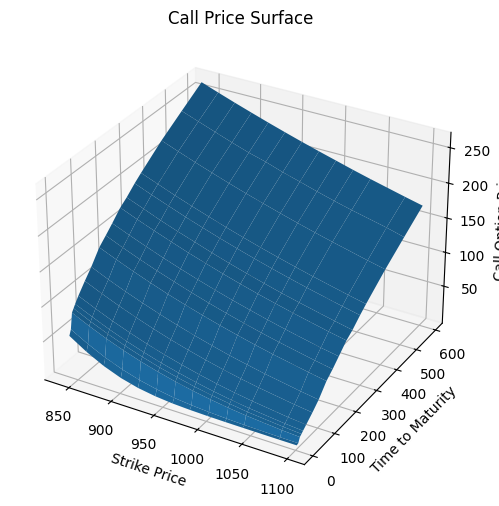

In [12]:
option_prices = option_prices.astype(float)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')
ax.set_title('Call Price Surface')
YY = option_prices.index
XX = option_prices.columns
XX, YY = np.meshgrid(XX, YY)
ZZ = option_prices.values
surf = ax.plot_surface(XX, YY, ZZ, rstride=1, cstride=1)

ax.set_xlabel('Strike Price')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Call Option Price')

plt.show()

In [13]:
def beta(i1,j1,i2,j2,df_prices, df_strikes):
    return (df_prices.iloc[i1,j1]-df_prices.iloc[i2,j2])/(df_strikes.iloc[i1,j1]-df_strikes.iloc[i2,j2])

def S_f(i1,j1,i2,j2,df_prices,df_strikes):
    if df_strikes.iloc[i1,j1] > df_strikes.iloc[i2,j2]:
        return -beta(i1,j1,i2,j2,df_prices,df_strikes)
    elif df_strikes.iloc[i1,j1] == df_strikes.iloc[i2,j2]:
        return df_prices.iloc[i2,j2] - df_prices.iloc[i1,j1]
    else:
        raise ValueError('Invalid strikes')

In [14]:
def v_1(df_prices):
    return np.sum(df_prices.iloc[:,-1:] < 0).values[0]

In [15]:
def v_2(df_prices, df_strikes):
    df_prices_shift=df_prices.shift(-1,axis=1)
    df_strikes_shift=df_strikes.shift(-1,axis=1)
    arb_1=(df_prices-df_prices_shift)/(df_strikes-df_strikes_shift)

    return np.sum(np.sum(arb_1.iloc[:,1:]>0.01)) + np.sum(arb_1.iloc[:,0]<-1.01)

In [16]:
def v_3(df_prices,df_strikes):
    df1 = (df_prices.shift(-1,axis=1)-df_prices)/(df_strikes.shift(-1,axis=1)-df_strikes)
    df2 = -(df_prices.shift(1,axis=1)-df_prices)/(df_strikes.shift(1,axis=1)-df_strikes)
    df3 = df1 + df2
    return np.sum(np.sum(df3 < -0.001))

In [17]:
def v_4(df_prices,df_strikes):
    
    number_of_violations=0
    for i in range(len(df_prices)-1):
        for j in range(len(df_prices.columns)):
            mask= (df_prices.iloc[i+1, j]< df_prices.iloc[i,j])
            number_of_violations+=mask
      
    return number_of_violations

In [18]:
def create_index_dictionaryI(df_strikes):
    index_dict = {}
    m, n = df_strikes.shape

    for i_star in range(m):
        for j_star in range(1, n):
            key = (i_star, j_star)
            strikes_i_star_j_star = df_strikes.iloc[i_star, j_star - 1]
            strikes_i_star_j_star_plus_1 = df_strikes.iloc[i_star, j_star]


            mask = (df_strikes.iloc[i_star+1:, :] > strikes_i_star_j_star) & (df_strikes.iloc[i_star+1:, :] < strikes_i_star_j_star_plus_1)

            indices = list(zip(*np.where(mask)))
            indices=[(i+i_star+1,j) for (i,j) in indices]
            index_dict[key] = indices

    return index_dict

def create_index_dictionaryI2(df_strikes):
    index_dict = {}
    m, n = df_strikes.shape

    for i_star in range(m):

        key = (i_star, n-1)
        strikes_i_star_n = df_strikes.iloc[i_star, n-1]
        mask = (df_strikes.iloc[i_star+1:, :] > strikes_i_star_n)
        indices = list(zip(*np.where(mask)))
        indices=[(i+i_star+1,j) for (i,j) in indices]

        index_dict[key] = indices

    return index_dict

def create_index_dictionaryI3(df_strikes):
    index_dict = {}
    m, n = df_strikes.shape

    for i_star in range(m):
        for j_star in range(n-1):
            key = (i_star, j_star)
            strikes_i_star_j_star = df_strikes.iloc[i_star, j_star ]
            strikes_i_star_j_star_plus_1 = df_strikes.iloc[i_star, j_star+1]


            mask = (df_strikes.iloc[i_star+1:, :] > strikes_i_star_j_star) & (df_strikes.iloc[i_star+1:, :] < strikes_i_star_j_star_plus_1)

            indices = list(zip(*np.where(mask)))
            indices=[(i+i_star+1,j) for (i,j) in indices]
            index_dict[key] = indices


    return index_dict

def create_index_dictionaryI4(df_strikes):
    index_dict = {}
    m, n = df_strikes.shape

    for i_star in range(m):

        key = (i_star, n-1)
        strikes_i_star_n = df_strikes.iloc[i_star, n-1]
        strikes_i_star_n_minus_1 = df_strikes.iloc[i_star, n-2]

        mask = (df_strikes.iloc[i_star+1:, :] > strikes_i_star_n_minus_1) & (df_strikes.iloc[i_star+1:, :] < strikes_i_star_n)

        indices = list(zip(*np.where(mask)))
        indices=[(i+i_star+1,j) for (i,j) in indices]


        index_dict[key] = indices

    return index_dict

In [19]:
def v_5(df_prices,df_strikes):
    dictio=create_index_dictionaryI(df_strikes)
    number_of_violations=0
    for key in dictio.keys():
        kis_js=df_strikes.iloc[key]
        cis_js=df_prices.iloc[key]
        for elem2 in dictio[key]:
            ki_j=df_strikes.iloc[elem2]
            ci_j=df_prices.iloc[elem2]
            if -(cis_js - ci_j)/(kis_js- ki_j)<-0.0001:
                number_of_violations+=1 
    return number_of_violations

In [20]:
def v_6_a(df_prices,df_strikes):
    dictioI1=create_index_dictionaryI(df_strikes)
    dictioI2=create_index_dictionaryI2(df_strikes)
    n,m=df_strikes.shape
    number_of_violations=0
    for key in dictioI1.keys():
        if key[1]!=m-1:
            kis_js=df_strikes.iloc[key]
            cis_js=df_prices.iloc[key]
            kis_js1=df_strikes.iloc[(key[0],key[1]+1)]
            cis_js1=df_prices.iloc[(key[0],key[1]+1)]
            
            for elem2 in dictioI1[key]:
                ki_j=df_strikes.iloc[elem2]
                ci_j=df_prices.iloc[elem2]
                if -(cis_js - ci_j)/(kis_js- ki_j) + (cis_js1 - cis_js)/(kis_js1- kis_js) <-0.001:
                    number_of_violations+=1 
    for key in dictioI1.keys():
        if key[1]>1:
            kis_jsm1=df_strikes.iloc[(key[0],key[1]-1)]
            cis_jsm1=df_prices.iloc[(key[0],key[1]-1)]
            kis_jsm2=df_strikes.iloc[(key[0],key[1]-2)]
            cis_jsm2=df_prices.iloc[(key[0],key[1]-2)]
            
            for elem2 in dictioI1[key]:
                ki_j=df_strikes.iloc[elem2]
                ci_j=df_prices.iloc[elem2]
                if -(cis_jsm1 - cis_jsm2)/(kis_jsm1- kis_jsm2) + (cis_jsm1 - ci_j)/(kis_jsm1- ki_j) <-0.001:
                    number_of_violations+=1 
    for key in dictioI2.keys():

        kis_jsm1=df_strikes.iloc[key]
        cis_jsm1=df_prices.iloc[key]
        kis_jsm2=df_strikes.iloc[(key[0],key[1]-1)]
        cis_jsm2=df_prices.iloc[(key[0],key[1]-1)]

        for elem2 in dictioI2[key]:
            ki_j=df_strikes.iloc[elem2]
            ci_j=df_prices.iloc[elem2]
            if -(cis_jsm1 - cis_jsm2)/(kis_jsm1- kis_jsm2) + (cis_jsm1 - ci_j)/(kis_jsm1- ki_j) <-0.001:
                number_of_violations+=1 

    return number_of_violations

def v_6_b(df_prices,df_strikes):

    dictioI1=create_index_dictionaryI(df_strikes)
    dictioI2=create_index_dictionaryI2(df_strikes)
    dictioI3=create_index_dictionaryI3(df_strikes)
    dictioI4=create_index_dictionaryI4(df_strikes)

    n,m=df_strikes.shape
    number_of_violations=0
    for key in dictioI1.keys():
        if key[1]!=0 and key[1]!=m-1 :
            kis_js=df_strikes.iloc[key]
            cis_js=df_prices.iloc[key]
            for elem in dictioI1[key]:
                
                ki1_j1=df_strikes.iloc[elem]
                ci1_j1=df_prices.iloc[elem]

                for elem2 in dictioI3[key]:
                    ki2_j2=df_strikes.iloc[elem2]
                    ci2_j2=df_prices.iloc[elem2]
                    if -(cis_js - ci1_j1)/(kis_js- ki1_j1) + (cis_js - ci2_j2)/(kis_js- ki2_j2) <-0.0001:
                        number_of_violations+=1 

    for key in dictioI2.keys():

        kis_js=df_strikes.iloc[key]
        cis_js=df_prices.iloc[key]
        for elem in dictioI2[key]:

            ki1_j1=df_strikes.iloc[elem]
            ci1_j1=df_prices.iloc[elem]

            for elem2 in dictioI4[key]:
                ki2_j2=df_strikes.iloc[elem2]
                ci2_j2=df_prices.iloc[elem2]
                if -(cis_js - ci1_j1)/(kis_js- ki1_j1) + (cis_js - ci2_j2)/(kis_js- ki2_j2) <-0.0001:
                    number_of_violations+=1 

    return number_of_violations

In [21]:
def violation_count(df_prices,df_strikes):
    v1,v2,v3,v4,v5=v_1(df_prices),v_2(df_prices,df_strikes),v_3(df_prices,df_strikes),v_4(df_prices,df_strikes),v_5(df_prices,df_strikes)
    v6=v_6_a(df_prices,df_strikes)+v_6_b(df_prices,df_strikes)
    print("Number of outright violations: "+ str(v1))
    print("Number of vertical spread violations: "+ str(v2))
    print("Number of vertical butterfly violations: "+ str(v3))
    print("Number of calendar spread violations: "+ str(v4))
    print("Number of calendar vertical spread violations: "+ str(v5))
    print("Number of calendar butterfly violations: "+ str(v6))

In [22]:
violation_count(option_prices_norm, strikes_norm)

Number of outright violations: 0
Number of vertical spread violations: 0
Number of vertical butterfly violations: 6
Number of calendar spread violations: 0
Number of calendar vertical spread violations: 0
Number of calendar butterfly violations: 0


In [23]:
def build_Ab_1(m, n, N):
    A1=np.zeros((m,N))
    for i in range(m):
        A1[i,(i+1)*n -1 ]=1
    b1=np.zeros((m,1))
    return A1, b1

In [24]:
def build_Ab_2(strikes_norm, m, n, N):
    A2=np.zeros((N,N))
    np.fill_diagonal(A2, 1)
    np.fill_diagonal(A2[:, 1:], -1)
    A2 = np.delete(A2, [n*(i+1)-1 for i in range(m)], axis=0)
    b2=np.zeros((N-m,1))

    A2bis=np.zeros((m,N))
    b2bis=np.zeros((m,1))
    for i in range(m):
        A2bis[i,n*i]=1 
        b2bis[i]=1-strikes_norm.iloc[i,1]

    return A2bis, b2bis

In [25]:
def build_Ab_3(strikes_norm, m, n, N):
    A3=np.zeros((N-2*m,N))

    count=0
    for i in range(m):
        for j in range(1,n-1):
            coeff_j_minus_1=1/(strikes_norm.iloc[i,j] - strikes_norm.iloc[i,j-1])
            coeff_j_plus_1=1/(strikes_norm.iloc[i,j] - strikes_norm.iloc[i,j+1])
            A3[count][i*n+j-1]=coeff_j_minus_1
            A3[count][i*n+j]=coeff_j_plus_1 -coeff_j_minus_1        
            A3[count][i*n+j+1]=-coeff_j_plus_1   
            count+=1
    b3=np.zeros((N-2*m,1))

    return A3, b3

In [26]:
def build_Ab_5(strikes_norm, n, N):
    dictioI5= create_index_dictionaryI(strikes_norm)
    s=sum(len(dictioI5[key]) for key in dictioI5.keys()) 
    A5=np.zeros((s,N))
    b5=np.zeros((s,1))
    count=0
    for key in dictioI5.keys():
        list_strikes=dictioI5[key]
        for x in list_strikes:
            A5[count,key[0]*n+ key[1]]=-1
            A5[count,x[0]*n+ x[1]]=1 
            count+=1 
    
    return A5, b5

In [27]:
def build_Ab_6_a(strikes_norm, n, N, dictio6a1, dictio6a2):
    sa1=sum(len(dictio6a1[key]) for key in dictio6a1.keys() if key[1]!=n-1) 
    A6a1=np.zeros((sa1,N))
    count=0
    for key in dictio6a1.keys():
        if key[1]!=n-1:
            list_strikes=dictio6a1[key]
            for x in list_strikes:
                den_i_j=1/(strikes_norm.iloc[key]-strikes_norm.iloc[x])
                den_is_js_p1=1/(strikes_norm.iloc[key[0],key[1]+1]-strikes_norm.iloc[key])
                A6a1[count,key[0]*n+ key[1]]=-(den_i_j + den_is_js_p1)
                A6a1[count,x[0]*n+ x[1]]=den_i_j
                A6a1[count,key[0]*n+ key[1]+1]=den_is_js_p1 
                count+=1 
    sa2=sum(len(dictio6a1[key]) for key in dictio6a1.keys() if key[1]>1) 
    A6a2=np.zeros((sa2,N))
    count=0
    for key in dictio6a1.keys():
        if key[1]>1:
            list_strikes=dictio6a1[key]
            for x in list_strikes:
                den_is_js_m1=1/(strikes_norm.iloc[key[0],key[1]-1]-strikes_norm.iloc[x])
                den_is_js_m2=1/(strikes_norm.iloc[key[0],key[1]-1]-strikes_norm.iloc[key[0],key[1]-2])
                A6a2[count,key[0]*n+ key[1]-1]=den_is_js_m1 - den_is_js_m2
                A6a2[count,key[0]*n+ key[1]-2]=den_is_js_m2 
                A6a2[count,x[0]*n+ x[1]]=-den_is_js_m1
                count+=1 
    sa3=sum(len(dictio6a2[key]) for key in dictio6a2.keys()) 
    A6a3=np.zeros((sa3,N))
    count=0
    for key in dictio6a2.keys():

        list_strikes=dictio6a2[key]
        for x in list_strikes:
            den_i_j=1/(strikes_norm.iloc[key[0],key[1]-1]-strikes_norm.iloc[key])
            den_is_js_m1=1/(strikes_norm.iloc[key]-strikes_norm.iloc[x])
            A6a3[count,key[0]*n+ key[1]-1]=den_i_j + den_is_js_p1
            A6a3[count,key[0]*n+ key[1]-2]=-den_i_j 
            A6a3[count,x[0]*n+ x[1]]=-den_is_js_p1
            count+=1 
    b6a1=np.zeros((sa1,1))
    b6a2=np.zeros((sa2,1))
    b6a3=np.zeros((sa3,1))

    return A6a1, A6a2, A6a3, b6a1, b6a2, b6a3

def build_Ab_6_b(strikes_norm, n, N, dictio6a1, dictio6a2):
    dictioI3 = create_index_dictionaryI3(strikes_norm)
    dictioI4 = create_index_dictionaryI4(strikes_norm)
    sa4=sum(len(dictio6a1[key])*len(dictioI3[key]) for key in dictio6a1.keys() if key[1]!=n-1) 
    A6b1=np.zeros((sa4,N))
    count=0
    for key in dictio6a1.keys():
        if key[1]!=n-1:
            list_strikes1=dictio6a1[key]
            list_strikes2=dictioI3[key]
            for x in list_strikes1:
                for y in list_strikes2:
                    den_i1_j1=1/(strikes_norm.iloc[key]-strikes_norm.iloc[x])
                    den_i2_j2=1/(strikes_norm.iloc[key]-strikes_norm.iloc[y])
                    A6b1[count,key[0]*n+ key[1]]=-den_i1_j1 + den_i2_j2
                    A6b1[count,x[0]*n+ x[1]]=den_i1_j1
                    A6b1[count,y[0]*n+ y[1]]=-den_i2_j2
                    count+=1

    sa5=sum(len(dictio6a2[key])*len(dictioI4[key]) for key in dictio6a2.keys()) 
    A6b2=np.zeros((sa5,N))
    count=0
    for key in dictio6a2.keys():
        list_strikes1=dictio6a2[key]
        list_strikes2=dictioI4[key]
        for x in list_strikes1:
            for y in list_strikes2:
                den_i1_j1=1/(strikes_norm.iloc[x]-strikes_norm.iloc[key])
                den_i2_j2=1/(strikes_norm.iloc[key]-strikes_norm.iloc[y])
                A6b1[count,key[0]*n+ key[1]]=den_i1_j1 + den_i2_j2
                A6b1[count,x[0]*n+ x[1]]=-den_i1_j1
                A6b1[count,y[0]*n+ y[1]]=-den_i2_j2
                count+=1
                
    b6b1=np.zeros((sa4,1))
    b6b2=np.zeros((sa5,1))

    return A6b1, A6b2, b6b1, b6b2

def build_Ab_6(strikes_norm, m, n, N):
    dictio6a1 = create_index_dictionaryI(strikes_norm)
    dictio6a2 = create_index_dictionaryI2(strikes_norm)
    
    A6a1, A6a2, A6a3, b6a1, b6a2, b6a3 = build_Ab_6_a(strikes_norm, n, N, dictio6a1, dictio6a2)
    A6b1, A6b2, b6b1, b6b2 = build_Ab_6_b(strikes_norm, n, N, dictio6a1, dictio6a2)

    return A6a1, A6a2, A6a3, b6a1, b6a2, b6a3, A6b1, A6b2, b6b1, b6b2

In [28]:
def build_Abc(strikes_norm, option_prices_norm):
    m=len(strikes_norm.index)
    n=len(strikes_norm.columns)
    N=n*m

    A1, b1 = build_Ab_1(m, n, N)
    A2, b2 = build_Ab_2(strikes_norm, m, n, N)
    A3, b3 = build_Ab_3(strikes_norm, m, n, N)
    
    A5, b5 = build_Ab_5(strikes_norm, n, N)
    A6a1, A6a2, A6a3, b6a1, b6a2, b6a3, A6b1, A6b2, b6b1, b6b2 = build_Ab_6(strikes_norm, m, n, N)

    # Need to add A4 and b4 when fixed
    A_opt = np.vstack((A1, A2, A3, A5, A6a1,A6a2,A6b1,A6b2))
    b_opt= np.vstack((b1, b2, b3, b5, b6a1,b6a2,b6b1,b6b2))
    c = option_prices_norm.values.flatten()

    return A_opt, b_opt, c

In [29]:
A, b, c = build_Abc(strikes_norm, option_prices_norm)

In [30]:
def l1(mat_A, vec_b, C, solver='glpk'):
    """
    Compute the perturbations needed to ensure arbitrage-free surface using
    the l1-norm objective.
    Minimise    ||epsilon||_l1
    s.t.        mat_A * (C + epsilon) >= vec_b
    Parameters
    ----------
    mat_A: 2D numpy.array, shape = (n_constraint, n_quote)
        The arbitrage-free constraint coefficient matrix.
    vec_b: 1D numpy.array, shape = (n_constraint,)
        The arbitrage-free constraint constant bound vector.
    C: 1D numpy.array, shape = (n_quote,)
        The call price vector.
    Returns
    -------
    epsilon: 1D numpy.array, shape = (n_quote, )
        The optimal perturbation vector, if the optimisation problem is
        solved successfully. Otherwise an empty list will be returned.
    """

    n_quote = mat_A.shape[1]
    MAX_ATTEMPTS = 8  # max number of attempts to solve the optimisation
    sol = []

    # Construct required quantities for the LP
    A = -np.hstack((mat_A, -mat_A))
    b = -(vec_b - mat_A.dot(C))
    coeff = np.ones(2 * n_quote)

    A1 = np.vstack((A, -np.diag(np.ones(2 * n_quote))))
    b1 = np.hstack((b, np.zeros(2 * n_quote)))
    G = matrix(A1)
    h = matrix(b1.astype(np.double))
    c = matrix(coeff)

    '''
    Scale the constraint for numerical stability
    A * (scale * epsilon) >= scale * b
    '''
    G *= 2.0
    h *= 2.0

    i_attempt = 1
    scale = .1
    status = 'initial'
    while status != 'optimal':
        scale *= 10
        c *= scale
        h *= scale

        # solve the LP
        sol = solvers.lp(c, G, h, solver=solver)
        status = sol['status']

        i_attempt += 1
        if i_attempt > MAX_ATTEMPTS:
            break

    if status == 'optimal':
        x = np.array(sol['x'])
        epsilon = x[:n_quote] - x[n_quote:]
        epsilon = epsilon.flatten()
        epsilon /= scale
    else:
        epsilon = []
        print('Optimal perturbation is not found after {} attempts!'.
              format(MAX_ATTEMPTS))

    return epsilon

In [31]:
def l1ba(mat_A, vec_b, C, spread=None, solver='glpk'):
    """
    Compute the perturbations needed to ensure arbitrage-free surface.
    Minimise    f(epsilon; spreads)
    s.t.        mat_A * (C + epsilon) >= vec_b
    Parameters
    ----------
    mat_A: 2D numpy.array, shape = (n_constraint, n_quote)
        The arbitrage-free constraint coefficient matrix.
    vec_b: 1D numpy.array, shape = (n_constraint,)
        The arbitrage-free constraint constant bound vector.
    C: 1D numpy.array, shape = (n_quote,)
        The call price vector.
    spread: 1d numpy.array, shape = (n_quote,)
        The bid-ask spread vector.
    Returns
    -------
    epsilon: 1d numpy.array, shape = (n_quote, )
        The optimal perturbation vector, if the optimisation problem is
        solved successfully. Otherwise an empty list will be returned.
    """

    n_quote = mat_A.shape[1]
    MAX_ATTEMPTS = 2  # max number of attempts to solve the optimisation
    sol = []

    if spread is None:
        print('No spread data have been provided, so the l1-norm objecitve is '
              'used automatically.')
        return l1(mat_A, vec_b, C)
    else:
        try:
            delta_ask = spread[0]
            delta_bid = spread[1]
            delta0 = np.min([np.min(delta_ask), np.min(delta_bid)])
            delta0 = 1./len(delta_ask) if delta0 > 1./len(delta_ask) else delta0
            delta0 = 1e-8 if delta0 < 1e-8 else delta0
        except ValueError:
            raise  ValueError('Please ensure that the spread input has legal '
                              'format! It should contain two arrays/lists, one '
                              'for bid-reference spread, one for ask-reference '
                              'spread.')

        # Construct required quantities for the LP
        I = np.eye(n_quote)
        B2_bid = np.diag(delta_bid) / delta0
        B2_ask = np.diag(delta_ask) / delta0
        O = np.zeros([mat_A.shape[0], n_quote])
        B = np.block([
            [-I, -I],
            [I, -I],
            [-I, -B2_bid],
            [I, -B2_ask],
            [-mat_A, O]
        ])
        d = np.hstack([delta_bid - delta0,
                        delta_ask - delta0,
                        np.zeros(2 * n_quote),
                        -vec_b + mat_A.dot(C)])
        coeff = np.hstack([np.zeros(n_quote), np.ones(n_quote)])

        G = matrix(B)
        h = matrix(d.astype(np.double))
        c = matrix(coeff)

        '''
        Scale the constraint for numerical stability
        A * (scale * epsilon) >= scale * b
        '''
        i_attempt = 1
        scale = .1
        status = 'initial'
        while status != 'optimal':
            scale *= 10
            c *= scale
            h *= scale

            # Solve the LP
            sol = solvers.lp(c, G, h, solver=solver)
            status = sol['status']

            i_attempt += 1
            if i_attempt > MAX_ATTEMPTS:
                break

        if status == 'optimal':
            epsilon = np.array(sol['x'])[:n_quote]
            epsilon = epsilon.flatten()
            epsilon /= scale
        else:
            epsilon = []
            print('Optimal perturbation is not found after {} attempts!'.
                  format(MAX_ATTEMPTS))

    return epsilon

In [32]:
epsilon = l1(A, b.flatten(), c, solver='glpk')
new_prices = c + epsilon
call_prices_l1_norm = pd.DataFrame(index=maturities_frac,columns=strikes_norm.columns,data=new_prices.reshape((len(maturities_frac),len(strikes_norm.columns))))
call_prices_l1 = call_prices_l1_norm.apply(lambda x: x/D(x.index)*S, axis=0)

GLPK Simplex Optimizer 5.0
27365 rows, 504 columns, 157548 non-zeros
      0: obj =   0.000000000e+00 inf =   3.113e-01 (6)
     12: obj =   1.828417851e-03 inf =   0.000e+00 (0)
Perturbing LP to avoid stalling [211]...
Removing LP perturbation [503]...
*   503: obj =   1.828417851e-03 inf =   7.681e-17 (0)
OPTIMAL LP SOLUTION FOUND


In [33]:
violation_count(call_prices_l1_norm, strikes_norm)

Number of outright violations: 0
Number of vertical spread violations: 0
Number of vertical butterfly violations: 0
Number of calendar spread violations: 0
Number of calendar vertical spread violations: 0
Number of calendar butterfly violations: 0


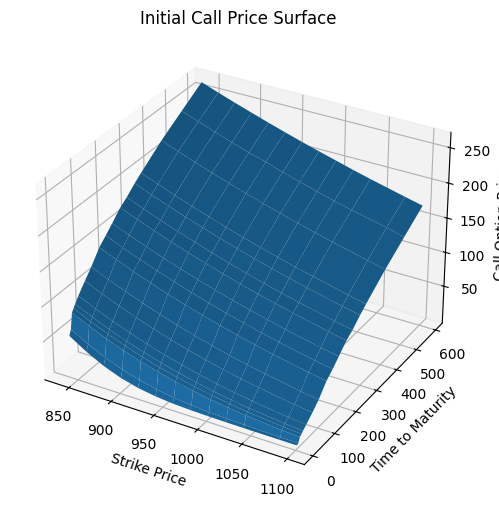

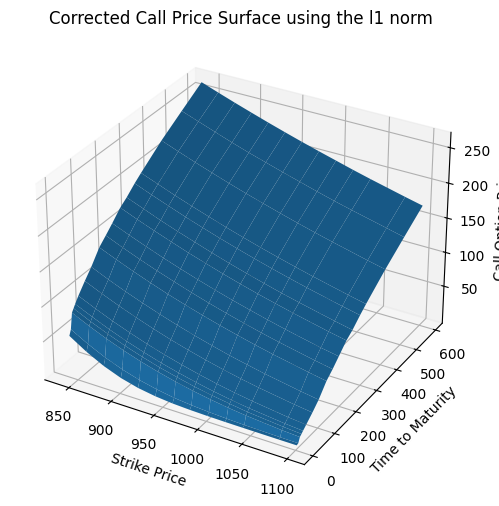

In [34]:
call_prices_l1 = call_prices_l1.astype(float)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')
ax.set_title('Initial Call Price Surface ')
YY = option_prices.index
XX = option_prices.columns
XX, YY = np.meshgrid(XX, YY)
ZZ = option_prices.values
surf = ax.plot_surface(XX, YY, ZZ, rstride=1, cstride=1)

ax.set_xlabel('Strike Price')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Call Option Price')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')
ax.set_title('Corrected Call Price Surface using the l1 norm')
YY = call_prices_l1.iloc[:, 1:].index
XX = call_prices_l1.iloc[:, 1:].columns
XX, YY = np.meshgrid(XX, YY)
ZZ = call_prices_l1.iloc[:, 1:].values
surf = ax.plot_surface(XX, YY, ZZ, rstride=1, cstride=1)

ax.set_xlabel('Strike Price')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Call Option Price')

plt.show()

In [35]:
def stress_test(A, b, arb_free_prices, lda, sigma):
    N=len(arb_free_prices.values.flatten())
    n_perturbation=int(lda*N)
    x=np.zeros(N)
    positions=np.random.choice(np.arange(N), n_perturbation, replace=False)
    x[positions]=np.random.normal(0, sigma, n_perturbation)
    x=np.exp(x)
    
    perturbed_prices=pd.DataFrame(index=arb_free_prices.index,columns=strikes,data=(arb_free_prices.values.flatten()*x).reshape((len(arb_free_prices.index),len(arb_free_prices.columns))))
    perturbed_prices_norm=perturbed_prices.apply(lambda x: x*D(x.index)/S, axis=0)
    perturbed_prices_norm.insert(loc=0, column=0.0, value=[1]*len(perturbed_prices_norm.index))

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(projection='3d')
    ax.set_title('Perturbed surface of call price with gaussian noise')
    YY = perturbed_prices.index
    XX = perturbed_prices.columns
    XX, YY = np.meshgrid(XX, YY)
    ZZ = perturbed_prices.values
    surf = ax.plot_surface(XX, YY, ZZ, rstride=1, cstride=1)
    
    ax.set_xlabel('Strike Price')
    ax.set_ylabel('Time to Maturity')
    ax.set_zlabel('Call Option Price')
    plt.show()

    violation_count(perturbed_prices_norm, strikes_norm)
    
    A, b, c = build_Abc(strikes_norm, option_prices_norm)
    epsilon = l1(A, b.flatten(), c, solver='glpk')
    new_prices = c + epsilon
    new_prices_l1_norm = pd.DataFrame(index=maturities_frac,columns=strikes_norm.columns,data=new_prices.reshape((len(maturities_frac),len(strikes_norm.columns))))
    new_prices_l1 = new_prices_l1_norm.apply(lambda x: x/D(x.index)*S, axis=0)
    
    new_prices_l1 = new_prices_l1.astype(float)
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(projection='3d')
    ax.set_title('Corrected Call Price Surface using the l1 norm')
    YY = call_prices_l1.iloc[:, 1:].index
    XX = call_prices_l1.iloc[:, 1:].columns
    XX, YY = np.meshgrid(XX, YY)
    ZZ = call_prices_l1.iloc[:, 1:].values
    surf = ax.plot_surface(XX, YY, ZZ, rstride=1, cstride=1)

    ax.set_xlabel('Strike Price')
    ax.set_ylabel('Time to Maturity')
    ax.set_zlabel('Call Option Price')
    plt.show()
    
    violation_count(new_prices_l1_norm, strikes_norm)

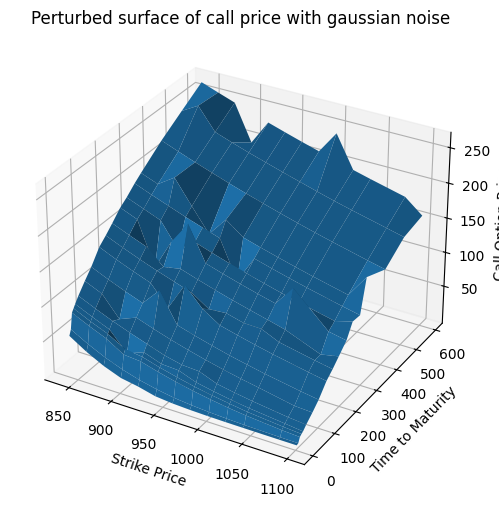

Number of outright violations: 0
Number of vertical spread violations: 19
Number of vertical butterfly violations: 39
Number of calendar spread violations: 18
Number of calendar vertical spread violations: 35
Number of calendar butterfly violations: 274
GLPK Simplex Optimizer 5.0
27365 rows, 504 columns, 157548 non-zeros
      0: obj =   0.000000000e+00 inf =   3.113e-01 (6)
     12: obj =   1.828417851e-03 inf =   0.000e+00 (0)
Perturbing LP to avoid stalling [211]...
Removing LP perturbation [503]...
*   503: obj =   1.828417851e-03 inf =   7.681e-17 (0)
OPTIMAL LP SOLUTION FOUND


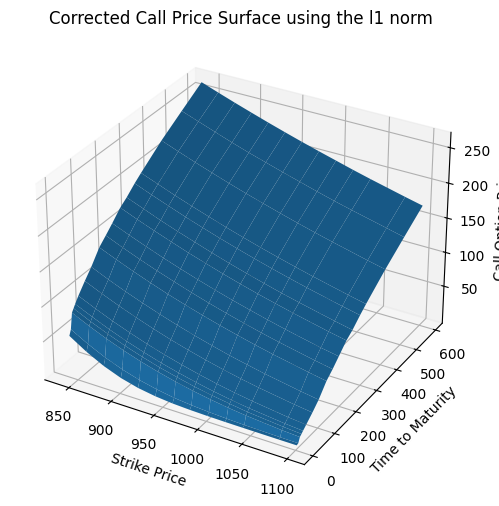

Number of outright violations: 0
Number of vertical spread violations: 0
Number of vertical butterfly violations: 0
Number of calendar spread violations: 0
Number of calendar vertical spread violations: 0
Number of calendar butterfly violations: 0


In [36]:
stress_test(A, b, call_prices_l1.iloc[:, 1:], 0.15, 0.15)